# <center> 👉 class_07_6 IP » _Distatnce Transformation_</center>
# <center> » _Labeling, Fill Colour, Watershed, Graph Cut, Mean Trans Filter_ </center>


## ▶ Distatnce Transformation  

In order to accurately identify the object area in an image, we need to __find the skeleton of the object area.__
One way to detect a skeleton is distance transformation, which is __a method of finding the point furthest from the outer boundary.__

이미지에서 물체 영역을 정확히 파악하기 위해서는 물체 영역의 뼈대를 찾아야 합니다.   
뼈대를 검출하는 방법 중 하나가 외곽 경계로부터 가장 멀리 떨어진 곳을 찾는 방법인 거리 변환입니다.   

- **cv2.distanceTransform(src, distanceType, maskSize)**  

- distanceType: cv2.DIST_L2, cv2.DIST_L1, cv2.DIST_L12, cv2.DIST_FAIR, cv2.DIST_WELSCH, cv2.DIST_HUBER


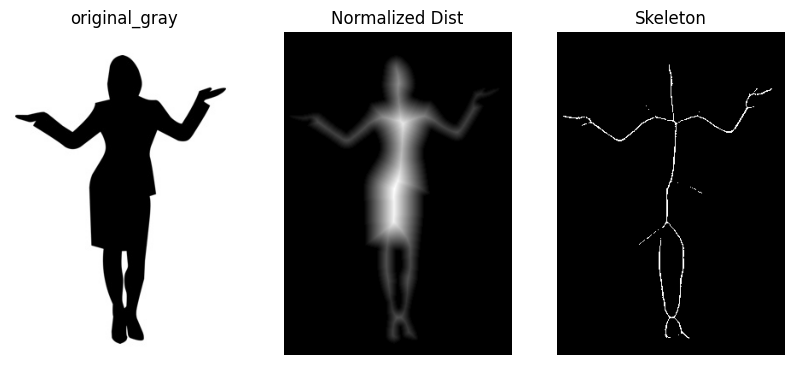

In [2]:
# distanceTrans.py : Finding a full body skeleton with distance transformation

import cv2
import numpy as np

img = cv2.imread('./images/practice_img/full_body.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('./images/practice_img/aircraft.jpg', cv2.IMREAD_GRAYSCALE)

_, biimg = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

dst = cv2.distanceTransform(biimg, cv2.DIST_L2, 5) 
dst = (dst/(dst.max()-dst.min()) * 255).astype(np.uint8) #  0 ~ 255 normaliize
skeleton = cv2.adaptiveThreshold(dst, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, -3)

cv2.imshow('origin', img)
cv2.imshow('Normalized dist', dst)
cv2.imshow('skel', skeleton)
cv2.waitKey(0)
cv2.destroyAllWindows()

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('original_gray'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Normalized Dist'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(skeleton, cv2.COLOR_BGR2RGB)),plt.title('Skeleton'),plt.axis('off')
plt.show()

## ▶ Labeling  

One of the ways to separate connected elements is called labeling.
As shown below, you can __separate parts of the image where the pixel value is not cut off by 0 by assigning the same value.__  

연결된 요소끼리 분리하는 방법 중 레이블링이라는 방법이 있습니다.   
아래와 같이 이미지에서 픽셀 값이 0으로 끊어지지 않는 부분끼리 같은 값을 부여해서 분리를 할 수 있습니다.     

<img src='./images/practice_img/dist_seg.png' width=400 height=400>  

- **retval, labels = cv2.connectedComponents(src, labels, connectivity=8, ltype):** 

>- src: Input image, binary scale
>- labels(optional): Array of the same size as the labeled input image
>- connectivity(optional): Number of directions to check connectivity (4 or 8)
>- ltype(optional): array of resulting labels
>- retval(optional): number of labels  
    
- retval, labels, stats, centroids = cv2.connectedComponentsWithStats(src, labels, stats, centroids, connectivity, ltype)
>- Returns various labeled status information (same result as cv2.connectedComponents)
>- stats: N x 5 array (N: number of labels) [x coord, y coord, width, height, area]
>- centroids: Coordinates of the center point of each label, N x 2   

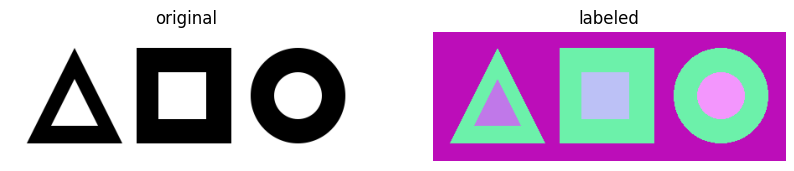

In [3]:
# connected_label.py

import cv2
import numpy as np

img = cv2.imread('./images/practice_img/shapes_donut.png')
img2 = np.zeros_like(img) 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
_, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
cnt, labels = cv2.connectedComponents(th) 
#retval, labels, stats, cent = cv2.connectedComponentsWithStats(th)

for i in range(cnt):
    img2[labels==i] =  [int(j) for j in np.random.randint(0,255, 3)] # Apply random colors to areas with the same label

cv2.imshow('origin', img)
cv2.imshow('labeled', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('labeled')

plt.show()

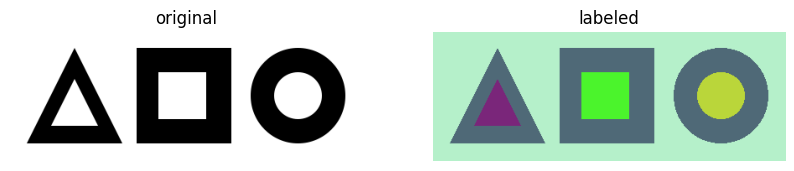

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('labeled')

plt.show()

You can see that the connected parts are painted the same color.   

## ▶ Flood Fill 색 채우기  
    
This function fills consecutive areas with the same color.  
연속되는 영역에 같은 색상을 채워 넣는 기능을 합니다.  

- **retval, img, mask, rect = cv2.floodFill(img, mask, seed, newVal, loDiff, upDiff, flags)**  

>- img: input img, 1 or 3 channel
>- mask: Array 2 x 2 pixels larger than the input image
>- seed: Coordinates to start filling
>- newVal: Color value to use for fill
>- loDiff, upDiff(optional): Min/max difference values that will determine fill progress 채우기 진행을 결정할 최소/최대 차이 값
>- flags(optional): cv2.FLOODFILL_MASK_ONLY, cv2.FLOODFILL_FIXED_RANGE:compare to seed pxl
>- retval: Number of pixels filled
>- rect: A rectangle surrounding the filled area.

This function starts from the seed coordinates of the img image and starts filling it with the value of newVal.
- At this time, to continue filling neighboring pixels, the current pixel must be greater than or equal to the neighboring pixel's loDiff minus its upDiff plus its value.
- This can be summarized as follows: (If loDiff and upDiff are omitted, only neighboring pixels with the same seed pixel value are filled.)  

    **neighboring pixel - loDiff <= current pixel <= neighboring pixel + upDiff**  

        이 함수는 img 이미지의 seed 좌표에서부터 시작해서 newVal의 값으로 채우기를 시작합니다.   
        이때 이웃하는 픽셀에 채우기를 계속하려면 현재 픽셀이 이웃 픽셀의 loDiff를 뺀 값보다 크거나 같고 upDiff를 더한 값보다 작거나 같아야 합니다.   
        이것을 식으로 정리하면 아래와 같습니다. (만약 loDiff와 upDiff를 생략하면 seed의 픽셀 값과 같은 값을 갖는 이웃 픽셀만 채우기를 진행합니다.)

- However, if **cv2.FLOODFILL_FIXED_RANGE** is passed to the last argument, flags, the color is filled by comparing with the seed pixel, not the neighboring pixel.
- Also, if **cv2.FLOODFILL_MASK_ONLY** is passed to flags, only the mask is filled, not the img.  

        - 하지만, 마지막 인자인 flags에 **cv2.FLOODFILL_FIXED_RANGE**가 전달되면 이웃 픽셀이 아닌 seed 픽셀과 비교하며 색을 채웁니다.   
        - 또한, flags에 **cv2.FLOODFILL_MASK_ONLY**가 전달되면 img에 채우기를 하지 않고 mask에만 채우기를 합니다. 

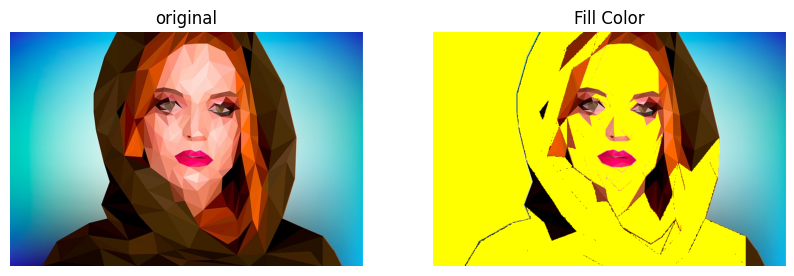

In [8]:
# flood_fill.py : with mouse event

import cv2
import numpy as np

img = cv2.imread('./images/practice_img/triangle_face.jpg')
# img = cv2.imread('./images/practice_img/mario2.png')
img_org = img.copy()
rows, cols = img.shape[:2]

mask = np.zeros((rows+2, cols+2), np.uint8) 
newVal = (0,255,255) 
loDiff, upDiff = (10,10,10), (10,10,10) # min max difference value

def onMouse(event, x, y, flags, param):
    global mask, img
    if event == cv2.EVENT_LBUTTONDOWN:
        seed = (x,y)
        retval = cv2.floodFill(img, mask, seed, newVal, loDiff, upDiff) 
        cv2.imshow('img', img) 

cv2.imshow('img', img)
cv2.setMouseCallback('img', onMouse)
cv2.waitKey(0)
cv2.destroyAllWindows()

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Fill Color')

plt.show()

## ▶ Watershed 

A watershed means __a boundary where river water flows in one stream and then diverges.__
Watershed can be viewed as finding a continuous area in a similar way to the color fill (flood fill) we looked at earlier.
However, you can specify multiple seeds instead of one, and these are called markers.  

        워터셰드란 하천이 하나의 하천으로 흐르다가 갈라지는 경계를 의미합니다.   
        워터셰드는 앞서 살펴본 색 채우기(flood fill)과 비슷한 방식으로 연속된 영역을 찾는 것이라고 볼 수 있습니다.   
        다만, seed를 하나가 아닌 여러 개를 지정할 수 있고 이를 마커라고 합니다. 

- **marker = cv2.watershed(img, markers)**  
>- markers: a one-dimensional array with the same row and column sizes as the input image (int32)

- Markers must be passed as a one-dimensional array with the same row and column sizes as the input image.  
- The value of markers is set to -1 for the pixel area where the boundary is to be found, and the same integer value for the remaining connected areas.  
- For example, 1 is the background, 2 is the foreground, and so on.  

        markers는 입력 이미지와 행과 열 크기가 같은 1차원 배열로 전달해야 합니다.   
        markers의 값은 경계를 찾고자 하는 픽셀 영역은 -1을 갖게 하고 나머지 연결된 영역에 대해서는 동일한 정수 값을 갖게 합니다.   
        예를 들어 1은 배경, 2는 전경인 식입니다.  

~ Example :  
This code separates the foreground and background of an image.   
- Drag the mouse to display the inside of the image as V or O,
- Also, the background is displayed separately.
- Then right-click to get an image with foreground and background separated.    
        이미지의 전경과 배경을 분리하는 코드입니다. 마우스를 드래그하여  내부를 표시(V or O)해주고,   
        또 배경도 따로 표시해줍니다.   
        그런 다음 오른쪽 마우스 버튼을 클릭하면 전경과 배경이 구분된 이미지를 얻을 수 있습니다.

>- marker = np.zeros((rows, cols), np.int32)  : create a marker
>- marker[y,x] = markerId  : multi seed 
>- cv2.watershed(img, marker)  : The area corresponding to the border is filled with -1, the foreground is filled with 1, and the background is filled with 2.
>- img_draw[marker == -1] = (255,255,255) : Image pixels with the same coordinates as the marker filled with -1(boundary) turn white.  
>- for mid, color in colors: 
                img_draw[marker==mid] = color  
        
Areas with the same marker ID value are filled with the same color.
- Filled with the pixel value of the coordinates when the left mouse button is first clicked.
Watershed can be used when boundary detection is difficult.
- You can find boundaries by specifying a few pixels that you can confidently be foreground or background.  
    
        같은 마커 아이디 값을 갖는 영역끼리 같은 색으로 채웁니다.   
        - 맨 처음 마우스 왼쪽 버튼을 클릭했을 때 좌표의 픽셀 값으로 채움.   
        워터셰드는 경계 검출이 어려운 경우 사용할 수 있습니다.   
        - 전경이나 배경으로 확신할 수 있는 몇몇 픽셀을 지정해줌으로써 경계를 찾을 수 있습니다.     

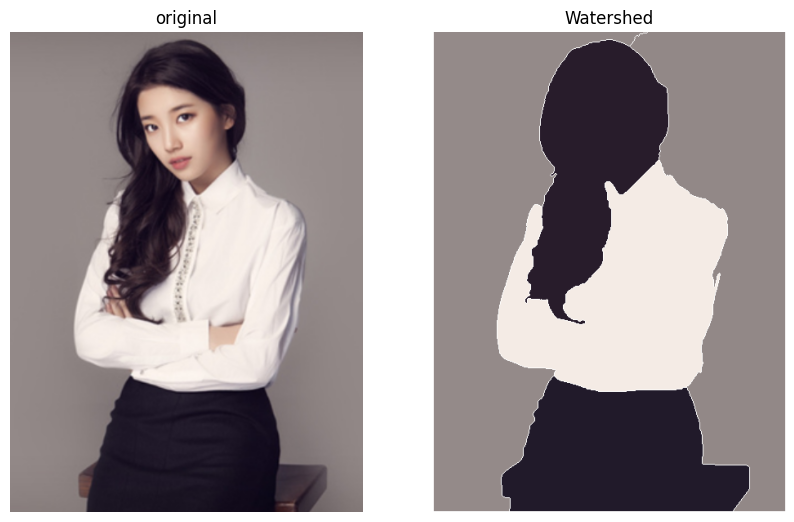

In [38]:
# watershed.py with mouse dragging

import cv2
import numpy as np

# img = cv2.imread('./images/practice_img/triangle_face.jpg')
img = cv2.imread('./images/practice_img/suji.png') 
rows, cols = img.shape[:2]
img_draw = img.copy()

marker = np.zeros((rows, cols), np.int32)
markerId = 1        # markerId starts from 1
colors = []         
isDragging = False  

def onMouse(event, x, y, flags, param):
    global img_draw, marker, markerId, isDragging
    if event == cv2.EVENT_LBUTTONDOWN:  
        isDragging = True
        colors.append((markerId, img[y,x]))
    elif event == cv2.EVENT_MOUSEMOVE: 
        if isDragging:                  
            marker[y,x] = markerId # Fill in the coordinates of the marker corresponding to the mouse coordinates with the same marker ID. ---②
            cv2.circle(img_draw, (x,y), 3, (0,0,255), -1) 
            cv2.imshow('watershed', img_draw)
    elif event == cv2.EVENT_LBUTTONUP:  
        if isDragging:                  
            isDragging = False         
            markerId +=1
    elif event == cv2.EVENT_RBUTTONDOWN: # RBUTTONDOWN
            cv2.watershed(img, marker)
            img_draw[marker == -1] = (255,255,255)
            for mid, color in colors: 
                img_draw[marker==mid] = color
            cv2.imshow('watershed', img_draw) 

cv2.imshow('watershed', img)
cv2.setMouseCallback('watershed', onMouse)
cv2.waitKey(0)
cv2.destroyAllWindows() 

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Watershed')

plt.show()

## ▶ Grab Cut

GrabCut estimates the color distribution of the foreground and background when the user marks the area to be separated into the foreground (non-background) and separates the foreground and background in a connected area with the same label.  
그랩컷은 사용자가 전경(배경이 아닌 부분)으로 분리할 부분에 사각형 표시를 해주면 전경과 배경의 색상 분포를 추정해서 동일한 레이블을 가진 연결된 영역에서 전경과 배경을 분리합니다.  

- **mask, bgdModel, fgdModel = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount, mode)**  

>- mask: same size of input img, 1 channel, 
>>- Stores a value that distinguishes between background and foreground   
>>>- cv2.GC_BGD: clear background(0),   
>>>- cv2.GC_FGD: clear foreground(1),   
>>>- cv2.GC_PR_BGD: prob background(2),   
>>>- cv2.GC_PR_FGD: prob foreground(3)
- rect: Rectangular coordinates of the area where the foreground is assumed to be 전경이 있을 것으로 추측되는 영역의 사각형 좌표, tuple(x1, y1, x2, y2)
- bgdModel, fgdModel: temporary array 
- mode(optional): 
>- cv2.GC_INIT_WITH_RECT: rect Grab Cut,   
>- cv2.GC_INIT_WITH_MASK: Grab Cut with mask  
>- cv2.GC_EVAL: set inintial mode (restart)  

If you pass cv2.GC_INIT_WITH_RECT to mode, the foreground and background are separated using the rectangular coordinates passed to the third parameter, rect.
- The result is assigned to the second parameter, mask, and returned.
- If the values assigned to the mask are 0 and 1, it means a clear background or foreground.
- 2 and 3 means it's probably background or foreground.
- You can obtain a more accurate mask by first distinguishing the background and foreground like this and then calling it again by specifying cv2.GC_INIT_WITH_MASK in mode.
- At this time, bgdModel and fgdModel are temporary arrays that the function uses internally for operations and are reused to reflect the previous operation in the next call, so their contents should not be modified.  
            
        mode에 cv2.GC_INIT_WITH_RECT를 전달하면 세 번째 파라미터인 rect에 전달한 사각형 좌표를 가지고 전경과 배경을 분리합니다.   
        그 결과를 두 번째 파라미터인 mask에 할당해 반환합니다.   
        mask에 할당받은 값이 0과 1이면 확실한 배경, 전경을 의미하고,   
        2와 3이면 아마도 배경, 전경일 가능성이 있다는 뜻입니다.   
        이렇게 1차적으로 배경과 전경을 구분한 뒤 mode에 cv2.GC_INIT_WITH_MASK를 지정해서 다시 호출하면 좀 더 정확한 mask를 얻을 수 있습니다.   
        이때 bgdModel과 fgdModel은 함수가 내부적으로 연산에 사용하는 임시 배열로 다음 호출 시 이전 연산을 반영하기 위해 재사용하므로 그 내용을 수정하면 안 됩니다. 

~ Example:   
- Drag with the mouse to mark the outer foreground area.
- First, the background and foreground are separated.
- If you want to further remove the background, hold down the Shift key and draw a black line with the mouse on the original image.
- If you want to add the foreground that was incorrectly removed, hold down the control key and draw a white line with the mouse on the original image.    
        - 마우스로 드래그하여 전경 외곽 영역을 표시해줍니다.   
        - 1차적으로 배경과 전경이 분리됩니다.   
        - 배경을 추가로 제거하고 싶으면 원본 이미지에 쉬프트 키를 누른 상태로 마우스로 검은색 선을 그어주면 됩니다.   
        - 잘못 제거된 전경을 추가하고 싶으면 원본 이미지에 컨트롤키를 누른 상태로 마우스로 흰색 선을 그어주면 됩니다.

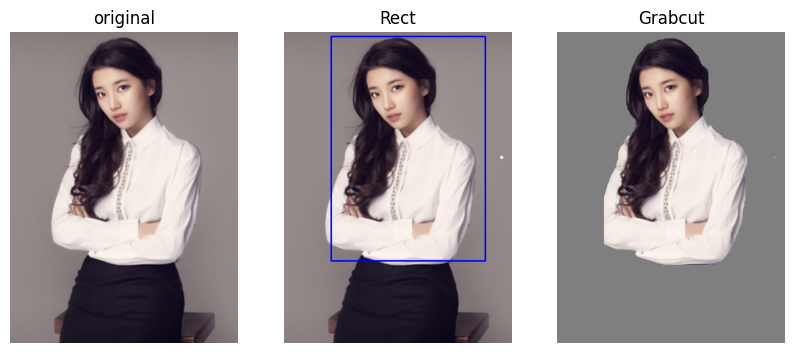

In [57]:
# grabcut.py

import cv2
import numpy as np

img = cv2.imread('./images/practice_img/suji.png')
img_draw = img.copy()
mask = np.zeros(img.shape[:2], dtype=np.uint8)  
rect = [0,0,0,0]   
mode = cv2.GC_EVAL  

bgdmodel = np.zeros((1,65),np.float64)
fgdmodel = np.zeros((1,65),np.float64)

def onMouse(event, x, y, flags, param):
    global mouse_mode, rect, mask, mode, img_gc
    if event == cv2.EVENT_LBUTTONDOWN : 
        if flags <= 1: 
            mode = cv2.GC_INIT_WITH_RECT 
            rect[:2] = x, y 
    elif event == cv2.EVENT_MOUSEMOVE and flags & cv2.EVENT_FLAG_LBUTTON :
        if mode == cv2.GC_INIT_WITH_RECT: 
            img_temp = img.copy()
            cv2.rectangle(img_temp, (rect[0], rect[1]), (x, y), (0,255,0), 2)
            cv2.imshow('img', img_temp)
        elif flags > 1: 
            mode = cv2.GC_INIT_WITH_MASK    
            if flags & cv2.EVENT_FLAG_CTRLKEY :
                cv2.circle(img_draw,(x,y),3, (255,255,255),-1)
                cv2.circle(mask,(x,y),3, cv2.GC_FGD,-1)  # CTRLKEY : FGD
            if flags & cv2.EVENT_FLAG_SHIFTKEY : 
                cv2.circle(img_draw,(x,y),3, (0,0,0),-1)
                cv2.circle(mask,(x,y),3, cv2.GC_BGD,-1)   # SHIFTKEY : BGD
            cv2.imshow('img', img_draw) 
    elif event == cv2.EVENT_LBUTTONUP: 
        if mode == cv2.GC_INIT_WITH_RECT : 
            rect[2:] =x, y 
            cv2.rectangle(img_draw, (rect[0], rect[1]), (x, y), (255,0,0), 2)
            cv2.imshow('img', img_draw)
        cv2.grabCut(img, mask, tuple(rect), bgdmodel, fgdmodel, 1, mode)
        img_gc = img.copy()
        img_gc[(mask==cv2.GC_BGD) | (mask==cv2.GC_PR_BGD)] = 127
        cv2.imshow('grabcut', img_gc) 
        mode = cv2.GC_EVAL 

cv2.imshow('img', img)
cv2.setMouseCallback('img', onMouse)
while True:    
    if cv2.waitKey(0) & 0xFF == 27 : # esc
        break
cv2.destroyAllWindows()

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Rect')
axs[2].imshow(cv2.cvtColor(img_gc, cv2.COLOR_BGR2RGB)), axs[2].axis('off'), axs[2].set_title('Grabcut')

plt.show()

In [ ]:
First, draw a rectangle by dragging the mouse.
- When calling cv2.grabCut(), set the mode to cv2.GC_INIT_WITH_RECT and call it.
Then, reflect the coordinates when the mouse is dragged while pressing the Shift or Control key in the mask, then call cv2.grabCut() at the time the mouse is released and pass cv2.GC_INIT_WITH_MASK to the mode.
- At this time, depending on the shift and control keys, the value to be reflected in the mask becomes cv2.GC_BGD or cv2.GC_FGD.  

        맨 처음 마우스 드래그로 사각형을 그립니다. 
        - cv2.grabCut()을 호출할 때 mode를 cv2.GC_INIT_WITH_RECT로 설정해서 호출
        그다음 쉬프트 or 컨트롤키를 누른 상태로 마우스 드래그를 해주었을 때의 좌표를 mask에 반영했다가 마우스 뗀 시점에 cv2.grabCut()을 호출하여 mode에 cv2.GC_INIT_WITH_MASK를 전달하면 됩니다.   
        - 이때 쉬프트와 컨트롤키에 따라 mask에 반영할 값이 cv2.GC_BGD 또는 cv2.GC_FGD가 됩니다. 

- And when the control/shift key is pressed, a white dot and a black dot are displayed on the screen, respectively.
- Also, at the mask index corresponding to the coordinates where the mouse moved, cv2.GC_FGD is a clear foreground, and cv2.GC_BGD is a clear background.  

        - 그리고 컨트롤/쉬프트 키가 눌렸을 때에 대해 각각 화면에 흰색 점, 검은색 점을 표시합니다.   
        - 또한 마우스가 움직인 좌표에 해당하는 mask 인덱스에 cv2.GC_FGD는 확실한 전경, cv2.GC_BGD는 확실한 배경
Remove the background by padding the coordinates corresponding to cv2.GC_BGD (definite background) and cv2.GC_PR_BGD (possible background) marked as background in the mask with 127.  

        - mask에서 배경으로 표시된 cv2.GC_BGD(확실한 배경), cv2.GC_PR_BGD(아마도 배경)에 해당하는 좌표를 127으로 채워서 배경을 제거합니다.   

> »cv2.grabCut(img, mask, tuple(rect), bgdmodel, fgdmodel, 1, mode)  
> »img2[(mask==cv2.GC_BGD) | (mask==cv2.GC_PR_BGD)] = 127 # Clearly or probably background, fill the area marked as background with 127 (gray)  
> »mode = cv2.GC_EVAL # Grabcut mode reset  

## ▶ Mean Shift Filtering (평균 이동 필터)  

Using the average shift filter, you can change the image like painting with paint.  

평균 이동 필터를 활용하면 물감으로 그림을 그린 것과 같이 이미지를 바꿀 수 있습니다.  

- **dst = cv2.pyrMeanShiftFiltering(src, sp, sr, dst, maxLevel, termcrit)**  

>- sp: Spatial window radius size 공간 윈도 반지름 크기
>- sr: Color Window Radius Size 색상 윈도 반지름 크기
>- maxLevel(optional): 이미지 피라미드 최대 레벨
>- termcrit(optional): Repeat stopping requirement 반복 중지 요건   
>>- cv2.TERM_CRITERIA_EPS: Stop when accuracy becomes less than minimum accuracy (default epsilon=1) 정확도가 최소 정확도(epsilon) 보다 작아지면 중지,   
>>- cv2.TERM_CRITERIA_MAX_ITER: max_iter : default max_iter=5   

This function internally creates an image pyramid and applies the average shift result from the small image to the large image.
So pyr is added in front of the function name.
- The input image is passed to src, which can be both gray scale and color scale.
- The sp parameter is the window size to use for MeanShift. It groups a few pixels and averages them to determine whether to move.
- The sr parameter specifies the range of difference in color values with the color window size.
>- When calculating the average, only pixels whose value difference is within the range of sr values are considered.
>- __Therefore, if sr is too small, there is not much difference from the original, and if sr is too large, it is very different from the original.__  
- maxLevel is the maximum level of the image pyramid.
>- If this value is greater than 0, the result obtained by averaging is shifted to an image pyramid smaller than that value.
>- __Larger values result in faster speeds but rougher areas and colors.__
- termcrit is a parameter that specifies the criteria for stopping repetition.  

이 함수는 내부적으로 이미지 피라미드를 만들어 작은 이미지의 평균 이동 결과를 큰 이미지에 적용합니다.   
그래서 함수 이름 앞에 pyr가 붙었습니다.   
- src에는 입력 이미지가 전달되는데 그레이 스케일과 컬러 스케일 모두 가능합니다.   
- sp 파라미터는 평균 이동(MeanShift)에 사용할 윈도 크기입니다. 몇 픽셀씩 묶어서 평균을 내어 이동할지를 결정합니다.   
- sr 파라미터는 색상 윈도 크기로 색상 값의 차이 범위를 지정합니다.   
>- 평균을 계산할 때 값의 차이가 sr 값의 범위 안에 있는 픽셀만을 대상으로 합니다.   
>- 따라서 sr이 너무 작으면 원본과 별 차이가 없고, 너무 크면 원본과 많이 달라집니다.   
- maxLevel은 이미지 피라미드 최대 레벨입니다.   
>- 이 값이 0보다 크면 그 값만큼 작은 이미지 피라미드로 평균 이동해서 얻은 결과를 적용합니다.   
>- 값이 클수록 속도가 빨라지지만 영역과 색상이 거칠어집니다.   
- termcrit은 반복을 중지할 기준을 지정하는 파라미터입니다. 

In [16]:
# mean_shift.py

import cv2
import numpy as np

img = cv2.imread('./images/practice_img/triangle_face.jpg')
img_org= img.copy()
def onChange(x):
    sp = cv2.getTrackbarPos('sp', 'img')
    sr = cv2.getTrackbarPos('sr', 'img')
    lv = cv2.getTrackbarPos('lv', 'img')

    mean = cv2.pyrMeanShiftFiltering(img, sp, sr, None, lv)
    cv2.imshow('img', np.hstack((img, mean)))
    print('sp =', sp,'sr =', sr,'maxlv =', lv )
                                  
cv2.imshow('img', np.hstack((img, img)))
cv2.createTrackbar('sp', 'img', 0,100, onChange)
cv2.createTrackbar('sr', 'img', 0,100, onChange)
cv2.createTrackbar('lv', 'img', 0,  5, onChange)
cv2.waitKey(0)
cv2.destroyAllWindows()

sp = 20 sr = 0 maxlv = 0
sp = 40 sr = 0 maxlv = 0
sp = 40 sr = 20 maxlv = 0
sp = 40 sr = 40 maxlv = 0
sp = 40 sr = 40 maxlv = 1
sp = 40 sr = 40 maxlv = 2
sp = 40 sr = 40 maxlv = 1
sp = 40 sr = 40 maxlv = 2
sp = 40 sr = 40 maxlv = 3


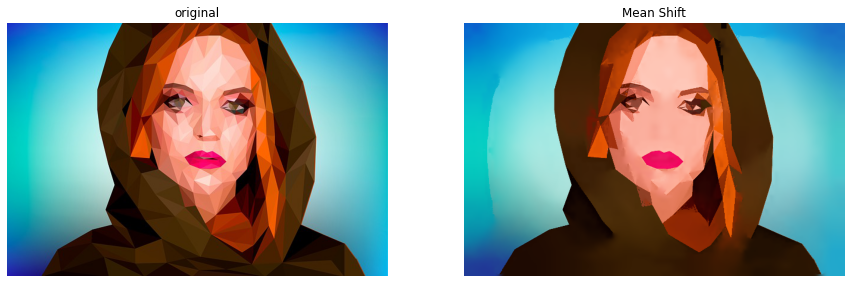

In [19]:
from matplotlib import pyplot as plt

img = cv2.imread('./images/practice_img/triangle_face.jpg')
mean = cv2.pyrMeanShiftFiltering(img, 40, 40, None, 3)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Mean Shift')

plt.show()

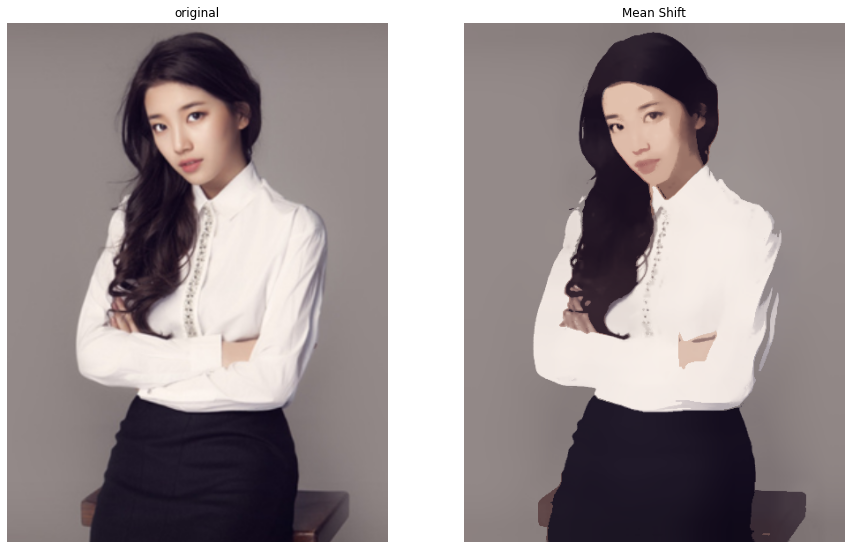

In [24]:
from matplotlib import pyplot as plt

img = cv2.imread('./images/practice_img/suji.png')
mean = cv2.pyrMeanShiftFiltering(img, 20, 40, None, 1)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Mean Shift')

plt.show()

End